# Showcase for ptdalgorithms

Python header:

In [1]:
%load_ext rpy2.ipython

from IPython.display import Image
from graphviz import Digraph
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
sns.set_style('ticks')
from matplotlib_inline.backend_inline import set_matplotlib_formats
set_matplotlib_formats('retina', 'png')

def plot_graph(states, ipv, sim, constrained=True, size='10'):

    constrained = constrained and 'true' or 'false'
    states = np.array(states)
    
    # add the missing row and col to SIM
    rates = np.r_[np.c_[sim, -sim.sum(axis=1)], np.zeros((1, len(sim)+1))]

    dot = Digraph()
    dot.node('S', 'S')
    for i in range(1, len(states)):
        dot.node(str(i), str(states[i]))
    for i in range(len(ipv)):
        if ipv[i]:
            dot.edge('S', str(i+1), constraint=constrained, label=str(ipv[i]))
    for i in range(1, len(states)):
        for j in range(1, len(states)):
            if i != j and rates[i-1, j-1] > 0:
                dot.edge(str(i), str(j), constraint=constrained, label=str(rates[i-1, j-1]))
    dot.graph_attr['size'] = size                
    return dot

R header:

In [2]:
%%R
library(tidyverse)

library(devtools)
#remove.packages("ptdalgorithms")

devtools::install_github("TobiasRoikjer/PtDAlgorithms")

library(ptdalgorithms)

R[write to console]: ── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

R[write to console]: ✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.6     ✔ dplyr   1.0.7
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

R[write to console]: ── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

R[write to console]: Indlæser krævet pakke: usethis

R[write to console]: Skipping install of 'ptdalgorithms' from a github remote, the SHA1 (d022b128) has not changed since last install.
  Use `force = TRUE` to force installation



## Standard coalescent

If you already have the subintensity matrix and initial probability vector:

In [11]:
%%R -o sim -o ipv
sim = matrix(c(-6, 6, 0, 0, 
               0, -3, 1, 2,
               0, 0, -1, 0,
               0, 0, 0, -1), nrow=4, ncol=4, byrow = TRUE)
ipv = c(1, 0, 0, 0)
sim

     [,1] [,2] [,3] [,4]
[1,]   -6    6    0    0
[2,]    0   -3    1    2
[3,]    0    0   -1    0
[4,]    0    0    0   -1


In [12]:
%%R 
graph <- matrix_as_graph(ipv, sim)

Note that the state vectors are ofcause undefined (all zero) when constructing the graph this way:

In [13]:
%%R
graph_as_matrix(graph)

$states
     [,1]
[1,]    0
[2,]    0
[3,]    0
[4,]    0

$SIM
     [,1] [,2] [,3] [,4]
[1,]   -6    6    0    0
[2,]    0   -3    1    2
[3,]    0    0   -1    0
[4,]    0    0    0   -1

$IPV
[1] 1 0 0 0



In [14]:
%%R
dph(0.9, graph)

[1] 0.5362689


If you want to generate the state space:

In [48]:
%%R -o states -o ipv -o sim
n <- 4
  
state_vector_length <- n
graph <- create_graph(state_vector_length)
starting_vertex <- vertex_at(graph, 1)
initial_state <- rep(0, n)
initial_state[1] <- n

add_edge(
  starting_vertex,
  create_vertex(graph, initial_state),
  1
)
index <- 2

while (index <= vertices_length(graph)) {
  vertex <- vertex_at(graph, index)
  
  # loop over all classes of lineages
  for (i in 1:n) {
    for (j in i:n) {
      state <- vertex$state
      
      # if same class, there need to be at least two to coalesce
      if (i == j) {
        if (state[i] < 2) {
          next;
        }
        # coal rate
        rate <- state[i] * (state[i] - 1) / 2
      } else {
        # else at least one in each class to coalesce
        if (state[i] < 1 || state[j] < 1) {
          next;
        }
        # number of combinations
        rate <- state[i] * state[j]
      }
      
      # copy state
      child_state <- state
      # update child state
      child_state[i] <- child_state[i] - 1
      child_state[j] <- child_state[j] - 1
      child_state[i+j] <- child_state[i+j] + 1
      
      add_edge(
          vertex,
          find_or_create_vertex(graph, child_state),
          rate, c(rate)
        )
    }
  }
      
  index <- index + 1
}

states <- t(sapply(1:vertices_length(graph), function(index) vertex_at(graph, index)$state ))
ipv <- graph_as_matrix(graph)$IPV
sim <- graph_as_matrix(graph)$SIM

vertices_length(graph)

[1] 6


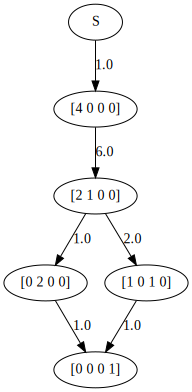

In [49]:
plot_graph(states, ipv, sim)

As matrices:

In [50]:
%%R -o states -o sim
matrices <- graph_as_matrix(graph)
states <- matrices$states
sim <- matrices$SIM
matrices

$states
     [,1] [,2] [,3] [,4]
[1,]    4    0    0    0
[2,]    2    1    0    0
[3,]    0    2    0    0
[4,]    1    0    1    0

$SIM
     [,1] [,2] [,3] [,4]
[1,]   -6    6    0    0
[2,]    0   -3    1    2
[3,]    0    0   -1    0
[4,]    0    0    0   -1

$IPV
[1] 1 0 0 0



Invert subintensity matrix to get Green matrix:

In [51]:
%%R
U <- -solve(matrices$SIM)
U

          [,1]      [,2]      [,3]      [,4]
[1,] 0.1666667 0.3333333 0.3333333 0.6666667
[2,] 0.0000000 0.3333333 0.3333333 0.6666667
[3,] 0.0000000 0.0000000 1.0000000 0.0000000
[4,] 0.0000000 0.0000000 0.0000000 1.0000000


Compute expectation from matrices:

In [52]:
%%R
matrices$IPV %*% U %*% rep(1, length(matrices$IPV))

     [,1]
[1,]  1.5


Compute moments:

In [53]:
%%R
expectation(graph)

[1] 1.5


INFO: building reward compute graph...


In [54]:
%%R
expected_waiting_time(graph)

[1] 1.500000 1.500000 1.333333 1.000000 1.000000 0.000000


In [55]:
%%R
variance(graph)

[1] 1.138889


In [56]:
%%R
2 * expected_waiting_time(graph, expected_waiting_time(graph)) - expected_waiting_time(graph) * expected_waiting_time(graph)

[1] 1.138889 1.138889 1.111111 1.000000 1.000000 0.000000


In [24]:
%%R
moments(graph, 4)

[1]  1.500000  3.388889 10.583333 42.907407


Marginal expectations using rewards:

In [25]:
%%R
state_matrix <- sapply(1:vertices_length(graph), function(index) vertex_at(graph, index)$state )
state_matrix

     [,1] [,2] [,3] [,4] [,5] [,6]
[1,]    0    4    2    0    1    0
[2,]    0    0    1    2    0    0
[3,]    0    0    0    0    1    0
[4,]    0    0    0    0    0    1


Rows happens to be our reward vectors. E.g. singleton rewards:

In [26]:
%%R
rewards <- sapply(1:vertices_length(graph), function(index) vertex_at(graph, index)$state )
singletons <- rewards[1,]
doubletons <- rewards[2,]
tripletons <- rewards[3,]
singletons

[1] 0 4 2 0 1 0


Expected tripleton branch length:

In [27]:
%%R
expectation(graph, tripletons)

[1] 0.6666667


SFS:

In [28]:
%%R -o sfs
sfs <- sapply(1:(dim(rewards)[1]-1), function(i) expectation(graph, rewards[i,]))
sfs

[1] 2.0000000 1.0000000 0.6666667


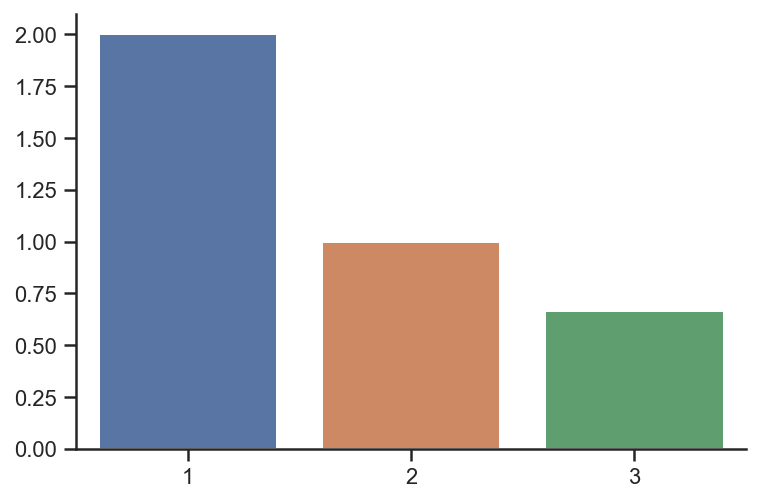

In [29]:
sns.barplot(x=list(range(1, len(sfs)+1)), y=sfs)
sns.despine()

Covariance:

In [30]:
%%R
covariance(graph, singletons, doubletons)

[1] -0.2222222


In [31]:
%%R
covariance(graph, singletons, tripletons)

[1] 0.8888889


Distributions of each "ton" branch length:

In [32]:
%%R -o result

result = data.frame()
for (i in 1:(dim(rewards)[1]-1)) {
    x <- seq(from = 0, to = 5, by = 0.01)
    pdf <- dph(x, reward_transform(graph, rewards[i, ]))
    df <- data.frame(prob = pdf, t=x, ton=i)
    result <- rbind(result, df)
}
#result %>% ggplot(aes(y=prob, x=t, color=ton, group=ton)) + geom_line(size=1)

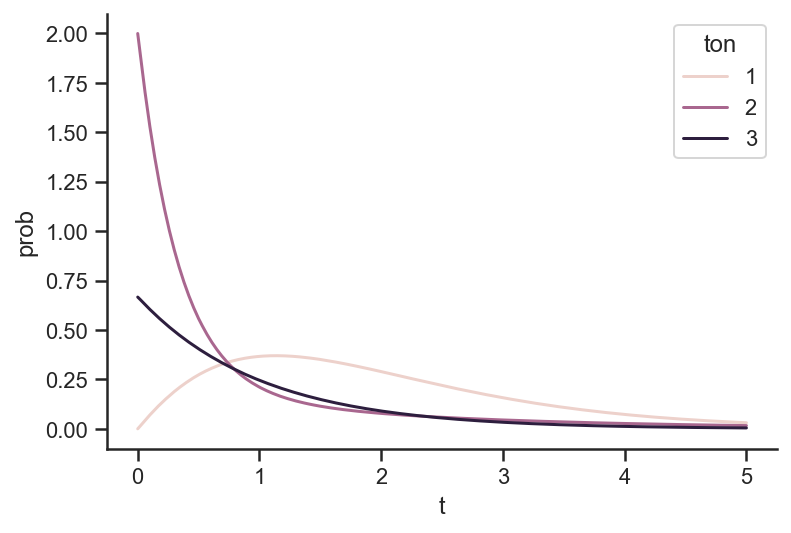

In [33]:
sns.lineplot(data=result, y='prob', x='t', hue='ton')
sns.despine()

Compute expectations from the distributions:

In [34]:
%%R -o sfs
ctx <- distribution_context(graph,1000)
prev_size <- 0
while (distribution_context_state(ctx)$cdf < 0.999) { 
    distribution_context_step(ctx)
}
expected_visits <- distribution_context_accumulated_visiting_time(ctx)
sfs <- sapply(1:(dim(rewards)[1]-1), function(i) sum(expected_visits * rewards[i,]))
sfs

[1] 1.9993341 0.9993341 0.6660008


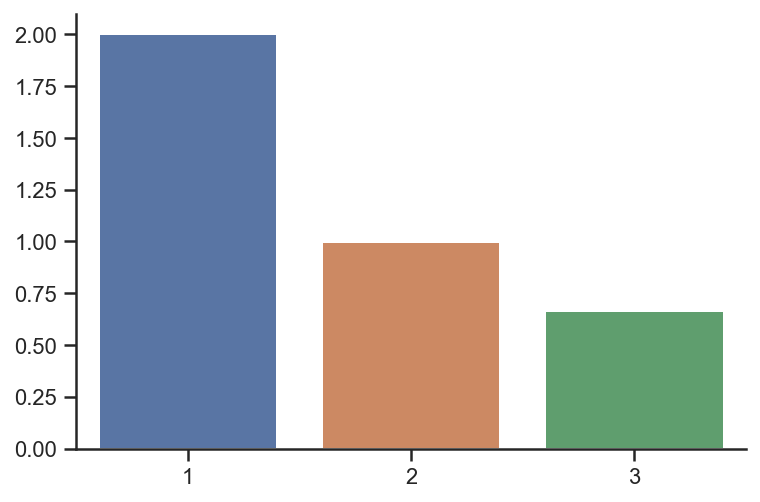

In [35]:
sns.barplot(x=list(range(1, len(sfs)+1)), y=sfs)
sns.despine()

Changing rates (edge weights) using parametrization:

In [36]:
%%R -o states -o ipv -o sim

graph_update_weights_parameterized(graph, c(2))

states <- t(sapply(1:vertices_length(graph), function(index) vertex_at(graph, index)$state ))
ipv <- graph_as_matrix(graph)$IPV
sim <- graph_as_matrix(graph)$SIM

Change rates back to normal:

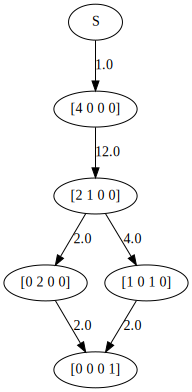

In [37]:
plot_graph(states, ipv, sim)

In [38]:
%%R -o states -o ipv -o sim

graph_update_weights_parameterized(graph, c(1))

states <- t(sapply(1:vertices_length(graph), function(index) vertex_at(graph, index)$state ))
ipv <- graph_as_matrix(graph)$IPV
sim <- graph_as_matrix(graph)$SIM

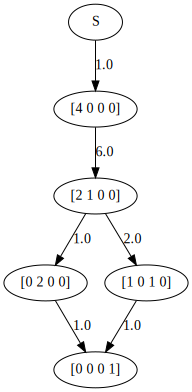

In [39]:
plot_graph(states, ipv, sim)

## Time-inhomgeneous coalescent

The distribution context is always made on the graph without rewards transformation. You can then:

- Get the distribution (and from that all moments) of time to absorbtion. Note that you cannot use dph for this as this assumes the current edge-weights and not seqentially updated ones in the distribution context.
- Get the marginal exepectations by summing over the products of the expected accumulated visiting times and rewards.


In [34]:
%%R -o cdf1 -o cdf2 -o cdf3

cdf_timeinhom <- function(graph, eqopues, sizes) {

    tmrca_pdf <- c()
    time <- c()
    
    ctx <- distribution_context(graph, 1000)
    prev_size <- 0
    while (distribution_context_state(ctx)$cdf < 0.999) { 
        tmrca_pdf[[(length(tmrca_pdf) + 1)]] <- distribution_context_state(ctx)$cdf
        time[[(length(time) + 1)]] <- distribution_context_state(ctx)$time
        
        size <- sizes[findInterval(distribution_context_state(ctx)$time, epoques)]
        if (size != prev_size) {
            graph_update_weights_parameterized(graph, c(1/size))
        }
        prev_size <- size
        distribution_context_step(ctx)
    }

    return(data.frame(prob = unlist(tmrca_pdf), t=unlist(time)))

}

epoques = c(0, 1, 2, 3, 4)
cdf1 <- cdf_timeinhom(graph, epoques, c(1, 1, 1, 1, 1))
cdf2 <- cdf_timeinhom(graph, epoques, c(1, 2, 4, 8, 16))
cdf3 <- cdf_timeinhom(graph, epoques, c(16, 8, 4, 2, 1))

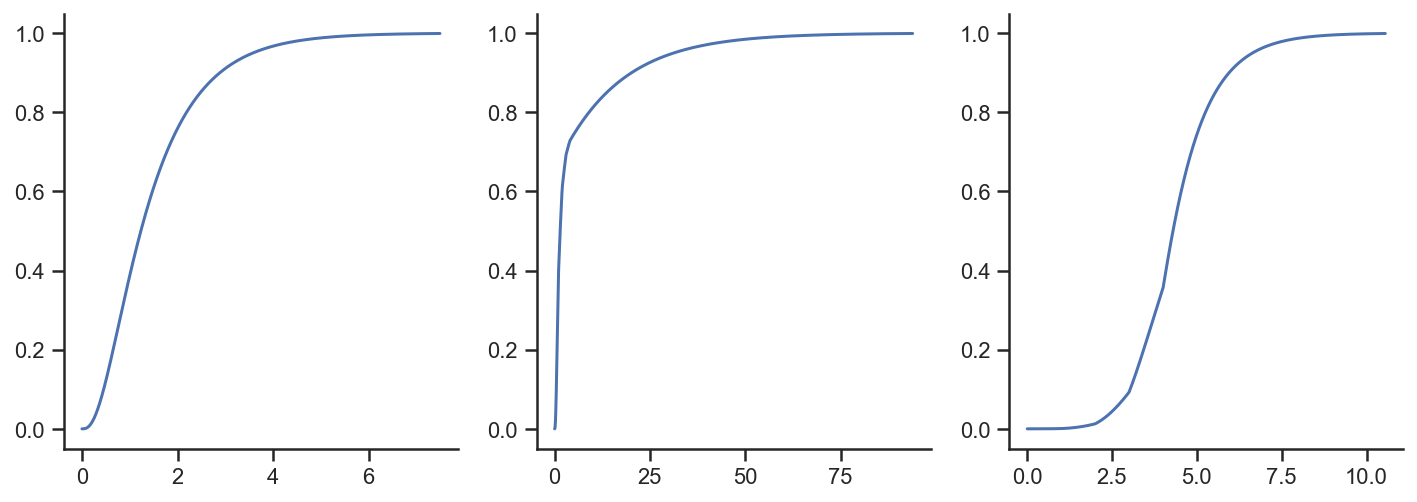

In [35]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
axes[0].plot(cdf1.t, cdf1.prob)
axes[1].plot(cdf2.t, cdf2.prob)
axes[2].plot(cdf3.t, cdf3.prob)
sns.despine()

In [36]:
%%R -o sfs1 -o sfs2 -o sfs3

sfs_timeinhom <- function(graph, eqopues, sizes) {

    tmrca_pdf <- c()
    time <- c()
    
    ctx <- distribution_context(graph, 1000)
    prev_size <- 0
    while (distribution_context_state(ctx)$cdf < 0.999) { 
        # tmrca_pdf <- c(tmrca_pdf, distribution_context_state(ctx)$pdf)
        # time <- c(time, distribution_context_state(ctx)$time)
        tmrca_pdf[[(length(tmrca_pdf) + 1)]] <- distribution_context_state(ctx)$pdf
        time[[(length(time) + 1)]] <- distribution_context_state(ctx)$time
        
        size <- sizes[findInterval(distribution_context_state(ctx)$time, epoques)]
        if (size != prev_size) {
            graph_update_weights_parameterized(graph, c(1/size))
        }
        prev_size <- size
        distribution_context_step(ctx)
    }
    expected_visits <- distribution_context_accumulated_visiting_time(ctx)
    
    sfs <- c()
    for (i in 1:(dim(rewards)[1]-1)) {
        sfs <- c(sfs, sum(expected_visits * rewards[i, ]))
    }
    return(sfs)
}

epoques = c(0, 1, 2, 3, 4)
sfs1 <- sfs_timeinhom(graph, epoques, c(1, 1, 1, 1, 1))
sfs2 <- sfs_timeinhom(graph, epoques, c(1, 2, 4, 8, 16))
sfs3 <- sfs_timeinhom(graph, epoques, c(16, 8, 4, 2, 1))

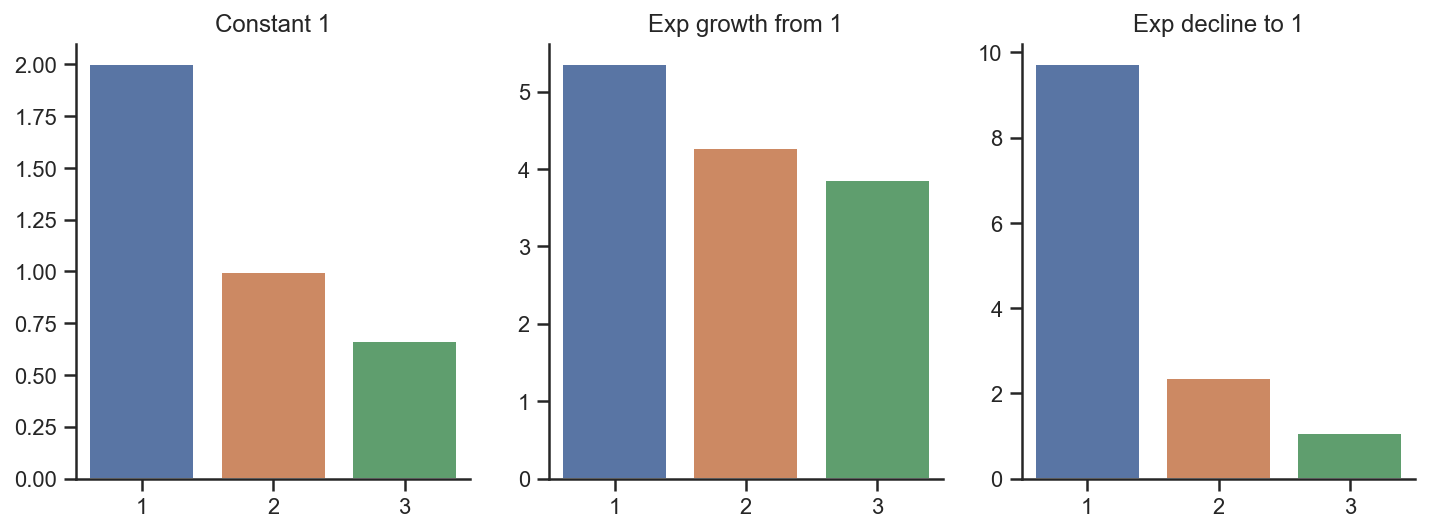

In [37]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
sns.barplot(x=list(range(1, len(sfs1)+1)), y=sfs1, ax=axes[0]).set_title("Constant 1")
sns.barplot(x=list(range(1, len(sfs2)+1)), y=sfs2, ax=axes[1]).set_title("Exp growth from 1")
sns.barplot(x=list(range(1, len(sfs3)+1)), y=sfs3, ax=axes[2]).set_title("Exp decline to 1")
sns.despine()

# Simple model in Keynote presentation

In [59]:
%%R -o states -o ipv -o sim

graph <- create_graph(1)

A <- create_vertex(graph, c(1))
B <- create_vertex(graph, c(2))
C <- create_vertex(graph, c(3))
D <- create_vertex(graph, c(4))

add_edge(starting_vertex(graph), A, 1)
add_edge(A, B, 0.12)
add_edge(A, D, 0.08)
add_edge(B, C, 0.25)
add_edge(B, D, 0.25)
add_edge(C, A, 0.2)

states <- t(sapply(1:vertices_length(graph), function(index) vertex_at(graph, index)$state, simplify = FALSE))
ipv <- graph_as_matrix(graph)$IPV
sim <- graph_as_matrix(graph)$SIM

vertices_length(graph)

[1] 5


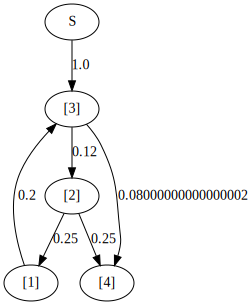

In [60]:
plot_graph(states, ipv, sim)

States:

In [61]:
%%R
expected_waiting_time(graph)

[1] 11 11 10 16  0


INFO: building reward compute graph...


Convert graph to matrix:

In [62]:
%%R
graph_as_matrix(graph)

$states
     [,1]
[1,]    3
[2,]    2
[3,]    1

$SIM
      [,1]  [,2] [,3]
[1,] -0.20  0.00  0.2
[2,]  0.25 -0.50  0.0
[3,]  0.00  0.12 -0.2

$IPV
[1] 0 0 1



Invert subintensity matrix to get Green matrix:

In [63]:
%%R -o U
U <- -solve(graph_as_matrix(graph)$SIM)
U

         [,1]     [,2]     [,3]
[1,] 7.142857 1.714286 7.142857
[2,] 3.571429 2.857143 3.571429
[3,] 2.142857 1.714286 7.142857


Sum first row of Green matrix to get expectation:

In [64]:
%%R
rowSums(U)

[1] 16 10 11


In [65]:
%%R
variance(graph)

[1] 139


In [66]:
%%R
r_prime <- expected_waiting_time(graph)
r_prime

[1] 11 11 10 16  0


In [69]:
%%R
2 * expected_waiting_time(graph, r_prime) - r_prime * r_prime

[1] 139 139 150 164   0


## Super simple model in Keynote presentation

Simplest possible model as example of how higher order moments are computed.

In [44]:
%%R -o states -o ipv -o sim

graph <- create_graph(1)

A <- create_vertex(graph, c(1))
B <- create_vertex(graph, c(2))
C <- create_vertex(graph, c(3))
D <- create_vertex(graph, c(4))

add_edge(starting_vertex(graph), A, 1)
add_edge(A, B, 1)
add_edge(B, C, 1)
add_edge(C, D, 1)

states <- t(sapply(1:vertices_length(graph), function(index) vertex_at(graph, index)$state, simplify = FALSE))
ipv <- graph_as_matrix(graph)$IPV
sim <- graph_as_matrix(graph)$SIM

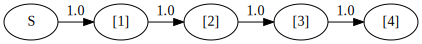

In [45]:
plot_graph(states, ipv, sim, constrained=False)

In [46]:
%%R
expected_waiting_time(graph)

[1] 3 3 2 1 0


INFO: building reward compute graph...


In [47]:
%%R
expected_waiting_time(graph, expected_waiting_time(graph))

[1] 6 6 3 1 0


In [48]:
%%R
moments(graph, 3)

[1]  3 12 60


In [49]:
%%R
2 * expected_waiting_time(graph, expected_waiting_time(graph)) - expected_waiting_time(graph) * expected_waiting_time(graph)

[1] 3 3 2 1 0


In [50]:
%%R
variance(graph)

[1] 3


# IM model

In [4]:
%%R
Rcpp::sourceCpp("./isolation_migration.cpp")

ld: warning: -pie being ignored. It is only used when linking a main executable


Comparing results for numerical accuracy for an "infinite" IM stage

In [52]:
%%R -o matrix_expectation -o algorithm_expectation -o simulation_expectation -o distribution_expectation 

n1 <- 4
n2 <- 4

g <- construct_im_graph(n1,n2,0.1,0.1)

expected_visits <- rep(0, vertices_length(g))
ctx <- distribution_context(g,1000)
while (distribution_context_state(ctx)$cdf < 0.9999) {
  distribution_context_step(ctx)
}
expected_visits <- distribution_context_accumulated_visiting_time(ctx)

distribution_expectation <- matrix(nrow=n1+1,ncol=n2+1)
algorithm_expectation <- matrix(nrow=n1+1,ncol=n2+1)
matrix_expectation <- matrix(nrow=n1+1,ncol=n2+1)
simulation_expectation <- matrix(nrow=n1+1,ncol=n2+1)
PH <- graph_as_matrix(g)
U <- solve(-PH$SIM)
set.seed(1234)

for (i in 0:n1) {
  for (j in 0:n2) {
    matrix_expectation[i+1,j+1] <-PH$IPV %*% U%*%diag(PH$states[,(matrix_index(i,j,0,n1,n2)+1)]+PH$states[,(matrix_index(i,j,1,n1,n2)+1)])%*%rep(1,length(PH$IPV))
    algorithm_expectation[i+1, j+1]<- expectation(g, rewards_at(g, i,j,n1,n2))
    distribution_expectation[i+1,j+1] <- sum(expected_visits * rewards_at(g, i,j,n1,n2))
    simulation_expectation[i+1, j+1]<- mean(rph(1000000, g, rewards_at(g, i,j,n1,n2)))
  }
}

print(sum(abs(matrix_expectation - algorithm_expectation)))
print(sum(abs(matrix_expectation - simulation_expectation)))
print(sum(abs(matrix_expectation - distribution_expectation)))

INFO: building reward compute graph...


[1] 1.353084e-14
[1] 0.04211939
[1] 0.001238273


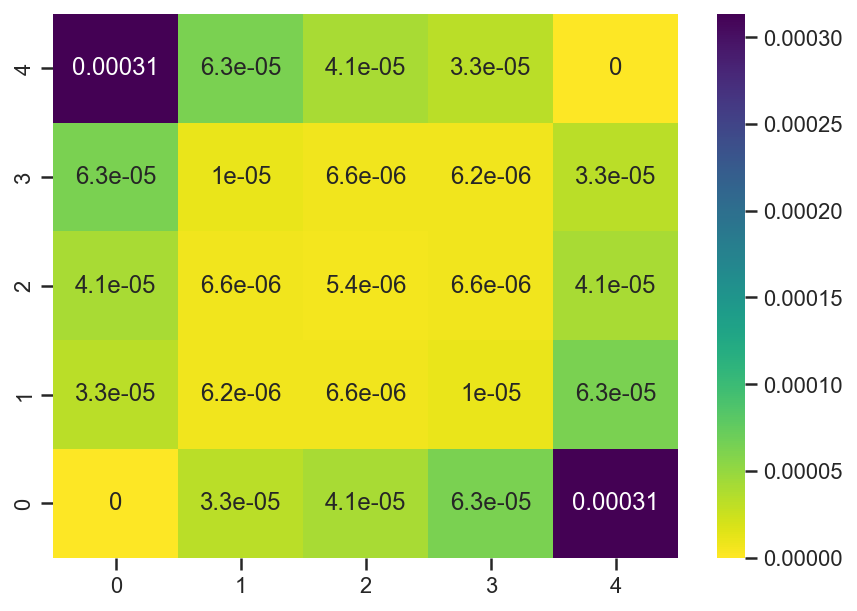

In [53]:
plt.subplots(1, 1, figsize=(7, 5))
ax = sns.heatmap(matrix_expectation - distribution_expectation, cmap="viridis_r", 
                annot=True
                )
ax.invert_yaxis()

The complete IM model with a split time and ancestral population:

In [6]:
%%time
%%R 

# parameters
n1 <- 7
n2 <- 7
m1 <- 1
m2 <- 1
split_t <- 1.5 # time in whatever unit used to scale transition probs (N generations)

# build im graph
im_g <- construct_im_graph(n1,n2,m1,m2)
cat(vertices_length(im_g), "\n")

# create ancestral graph
a_g <- construct_ancestral_graph(n1,n2)
cat(vertices_length(a_g), "\n")


123135 
2999 
CPU times: user 1.38 s, sys: 67.1 ms, total: 1.45 s
Wall time: 1.46 s


In [29]:
%%time
%%R -o n1 -o n2 -o m1 -o m2 -o split_t -o im_expectation -o a_expectation

# parameters
n1 <- 7
n2 <- 7
m12 <- 0.005
m21 <- 2
p1 <- 2
p2 <- 1
pa <- 4
split_t <- 3 # time in whatever unit used to scale transition probs (N generations)

# build im graph
im_g <- construct_im_graph(n1, n2, p1, p2, m12, m21)
cat(vertices_length(im_g), "\n")

im_expected_visits <- accumulated_visiting_time(im_g, split_t)

# create ancestral graph
a_g <- construct_ancestral_graph(n1, n2, pa)
cat(vertices_length(a_g), "\n")

# find probabilities of starting at each state in ancestral graph
start_prob <- start_prob_from_im(a_g, im_g, im_expected_visits)

# compute expectations for each graph
im_expectation <- matrix(nrow=n1+1,ncol=n2+1)
a_expectation <- matrix(nrow=n1+1,ncol=n2+1)
for (i in 0:n1) {
  for (j in 0:n2) {
    im_expectation[i+1,j+1] <- sum(im_expected_visits * rewards_at(im_g, i,j,n1,n2))
    a_expectation[i+1, j+1]<- sum(start_prob * expected_waiting_time(a_g, rewards_at(a_g, i,j,n1,n2)))
  }
}

123135 
2999 


INFO: building reward compute graph...


CPU times: user 37.2 s, sys: 249 ms, total: 37.4 s
Wall time: 37.7 s


In [30]:
pd.DataFrame(im_expectation).to_hdf(f'im_{int(n1)}_{int(n2)}_{float(m1)}_{float(m2)}_{float(split_t)}.h5', key='df', format='table')
pd.DataFrame(a_expectation).to_hdf(f'a_{int(n1)}_{int(n2)}.h5', key='df', format='table')

Expectation for inifinte IM stage:

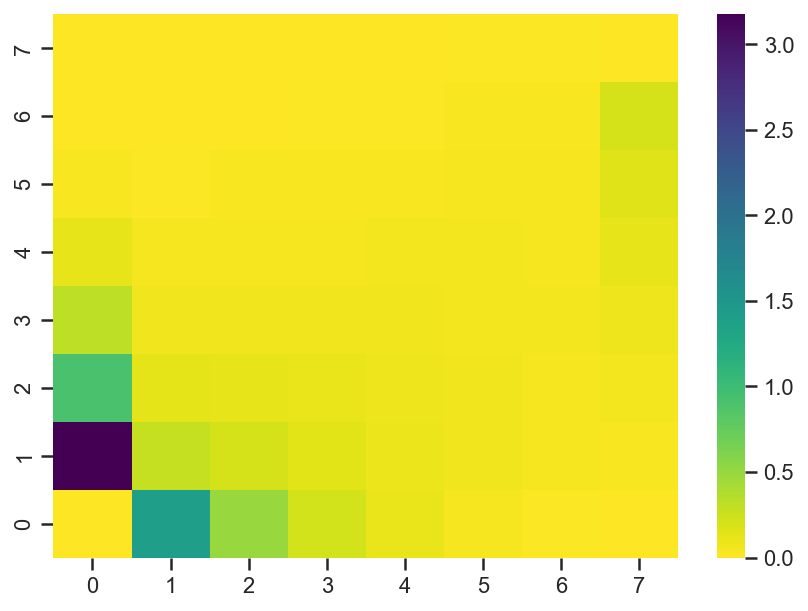

In [31]:
plt.subplots(1, 1, figsize=(7, 5))
ax = sns.heatmap(pd.DataFrame(im_expectation), cmap="viridis_r", 
#                annot=True
                )
ax.invert_yaxis()
plt.savefig('figures/im_stage.pdf')

Expectation for panmictic ancestral population:

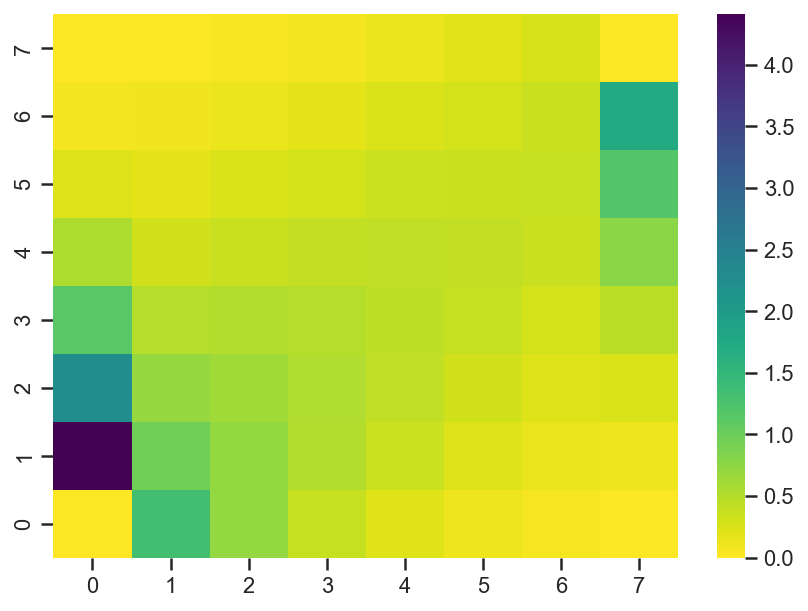

In [32]:
plt.subplots(1, 1, figsize=(7, 5))
ax = sns.heatmap(a_expectation, cmap="viridis_r", 
#                annot=True
                 
                )
ax.invert_yaxis()
plt.savefig('figures/a_stage.pdf')

Expectation for combined IM model with split time:

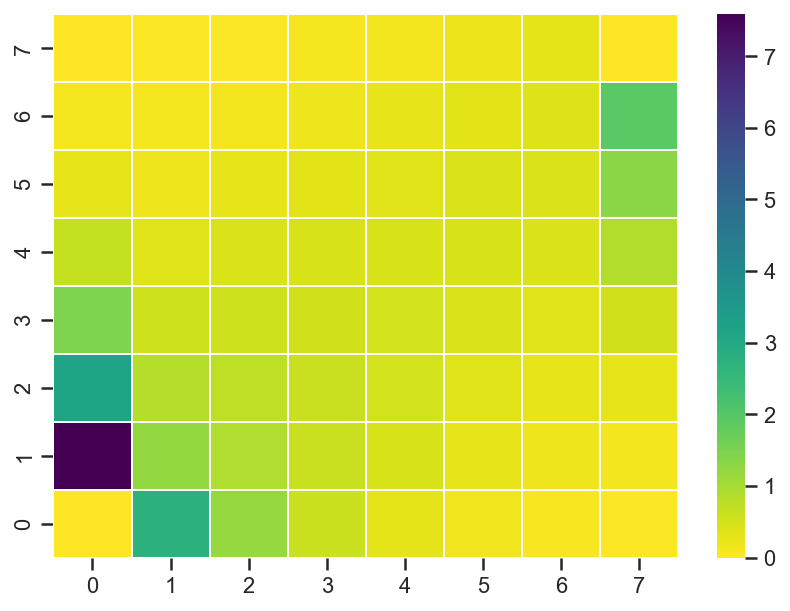

In [33]:
plt.subplots(1, 1, figsize=(7, 5))
ax = sns.heatmap(im_expectation + a_expectation, cmap="viridis_r", 
                # annot=True,
                 linewidths=1,
                 linecolor='white'
                )
ax.invert_yaxis()
plt.savefig(f"figures/im_{n1}_{n1}_{m1}_{m2}_{split_t}.pdf")

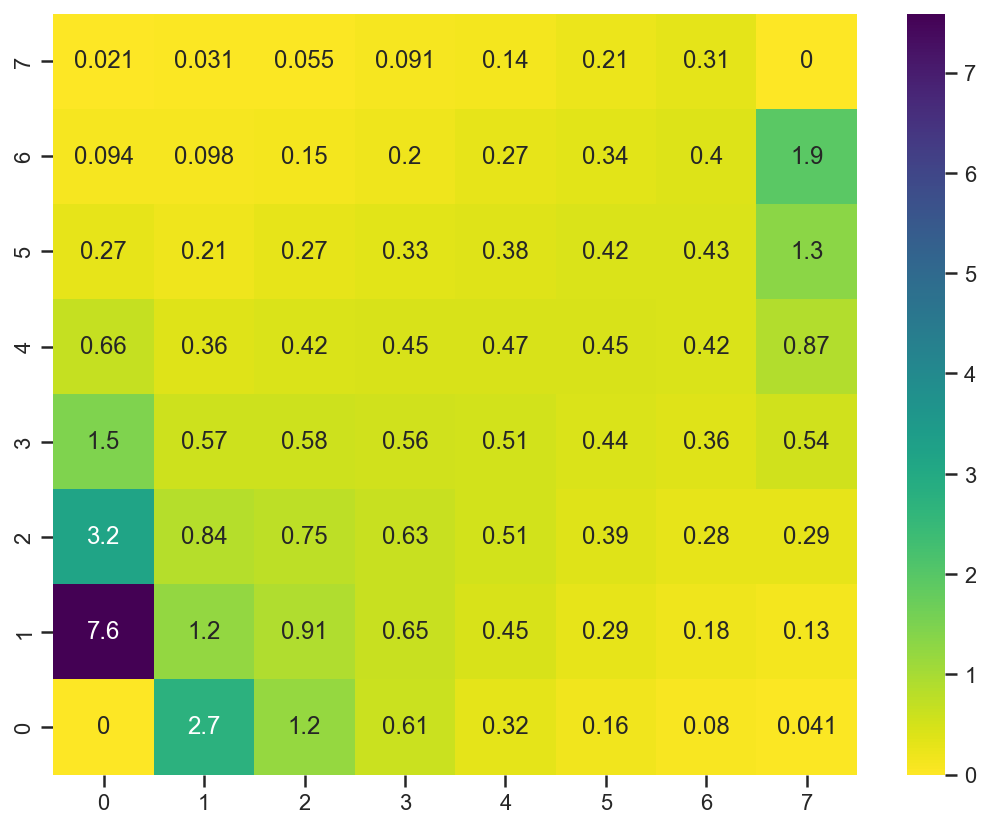

In [34]:
plt.subplots(1, 1, figsize=(9, 7))
ax = sns.heatmap(im_expectation + a_expectation, cmap="viridis_r", 
                annot=True
                )
ax.invert_yaxis()

## Model with two loci, two islands, and s samples

In [60]:
%%R
Rcpp::sourceCpp("./two_locus_two_island.cpp")

ld: warning: -pie being ignored. It is only used when linking a main executable


In [61]:
# %%R

# setClass("conf", slots=list(locus1="numeric", locus2="numeric", population="numeric"))

# obj <- new("conf", locus1=3, locus2=2, population=1)
# obj@population

# r_index_to_props <- function(s, i) {
#     #' returns the locus1, locus2, population
#     #' conformation of lineages represented by
#     #' state vector index i.
#     stopifnot(i > 0)
#     d <- s + 1 # dim
#     idx <- i - 1
#     p <- idx %/% d**2
#     stopifnot(i <= 2*d**2)
#     a <- (idx - p*d**2) %/% d
#     b <- (idx - p*d**2) %% d
#     return(new("conf", locus1=a, locus2=b, population=p+1))
# }
# r_props_to_index <- function(s, a, b, p) {
#     #' returns the state vector index representing
#     #' the locus1, locus2, population conformation.
#     d <- s + 1
#     i = (p-1)*d**2 + a*d + b + 1
#     return(i)
# }

In [62]:
# %%R
# n <- 2
# for (p in 1:2) {
#     for (i in 0:n) {
#         for (j in 0:n) {
#             print(props_to_index(n, i, j, p))
#             print(r_props_to_index(n, i, j, p))
#         }
#     }
# }

In [63]:
%%time
%%R -o s  -o outgoing_edge_counts
s <- 6
tli_graph <- construct_twolocus_island_graph(s, 1, 1, 1)
print(vertices_length(tli_graph))
si <- sign(graph_as_matrix(tli_graph)$SIM)
diag(si) <- 0
outgoing_edge_counts <- rowSums(si)
print(mean(outgoing_edge_counts))
# qplot(outgoing_edge_counts, bins=100, asp=1)

[1] 29920
[1] 11.24645
CPU times: user 53.6 s, sys: 28.8 s, total: 1min 22s
Wall time: 1min 33s


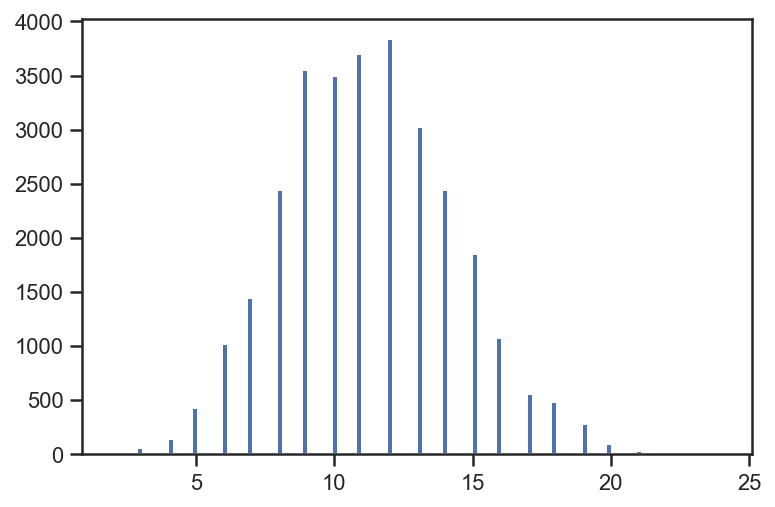

In [64]:
plt.hist(outgoing_edge_counts, bins=100) ;

In [65]:
%%time
%%R
expectation(tli_graph)

INFO: building reward compute graph...


[1] 5.027388
CPU times: user 3min 56s, sys: 5.75 s, total: 4min 1s
Wall time: 4min 6s


In [66]:
# %%R -o graph -o states -o ipv -o sim

# ###########################
# # sample size
# s <- 2
# ###########################

# # number of populations
# p <- 2 # needs to be 2
# # state vector length
# n <- p*(s+1)**2

# graph <- create_graph(n)
# index <- 1
# # first_vertex <- create_vertex(graph, c(rep(0, s+2), s, rep(0, n-s-3))) # assumes that p=2
# state <- rep(0, n)
# state[conf_to_index(s, 1, 1, 1)] <- s
# first_vertex <- create_vertex(graph, state) # assumes that p=2
# add_edge(starting_vertex(graph), first_vertex, 1)

# index <- 2
# while (index <= vertices_length(graph)) {
    
#   vertex <- vertex_at(graph, index)
#   state <- vertex$state
  
#   count <- 0
#   for (i in 1:n) {
#       count <- count + state[i]
#   }
#   if (count <= 1) {
#       # Only one lineage, stop
#       index <- index + 1
#       next
#   }    
    
#   for (i in 1:n) {
#     conf_i <- index_to_conf(s, i)
    
#     # coalescence #########################
#     for (j in i:n) {
#       conf_j <- index_to_conf(s, j)
      
#       if (conf_i@population != conf_j@population) {
#         # different populations
#         next
#       }
#       if (i == j) {
#         if (state[i] < 2) {
#           next;
#         }
#         rate <- state[i] * (state[i] - 1) / 2
#       } else {
#         if (state[i] < 1 || state[j] < 1) {
#           next;
#         }
#         rate <- state[i] * state[j]
#       }
      
#       child_state <- state
        
#       # lineages with index i and j coalesce:  
#       child_state[i] <- child_state[i] - 1
#       child_state[j] <- child_state[j] - 1
#       stopifnot(conf_i@locus1+conf_j@locus1 <= s)
#       stopifnot(conf_i@locus2+conf_j@locus2 <= s)

#       # coalescene into lineage with index k
#       k = conf_to_index(s, conf_i@locus1+conf_j@locus1, conf_i@locus2+conf_j@locus2, conf_i@population)
#       child_state[k] <- child_state[k] + 1
      
#       child_vertex <- find_or_create_vertex(graph, child_state)
#       add_edge(vertex, child_vertex, rate)
#     }
    
#     # recombination #######################
#     if (state[i] > 0 && conf_i@locus1 > 0 && conf_i@locus2 > 0) {
      
#       rate <- 3
#       child_state <- state
        
#       # a lineage with index i recombines to produce lineages with index k and l
#       k = conf_to_index(s, conf_i@locus1, 0, conf_i@population)
#       l = conf_to_index(s, 0, conf_i@locus2, conf_i@population)
#       child_state[i] <- child_state[i] - 1
#       child_state[k] <- child_state[k] + 1
#       child_state[l] <- child_state[l] + 1
      
#       child_vertex <- find_or_create_vertex(graph, child_state)
#       add_edge(vertex, child_vertex, rate)
#     }
    
#     # migration ###########################
#     if (state[i] > 0) {
      
#       rate <- 0.001
#       child_state <- state
        
#       if (conf_i@population == 1) {
#         m = 2
#       } else {
#         m = 1
#       }
#       # 
#       k = conf_to_index(s, conf_i@locus1, conf_i@locus2, m)
#       child_state[i] <- child_state[i] - 1
#       child_state[k] <- child_state[k] + 1
      
#       child_vertex <- find_or_create_vertex(graph, child_state)
#       add_edge(vertex, child_vertex, rate)
#     }
#   }
  
#   index <- index + 1
    
#   if ((index %% 50) == 0) {
#     cat(index, vertices_length(graph), "\n")
#   }
    
# }

# states <- t(sapply(1:vertices_length(graph), function(index) vertex_at(graph, index)$state, simplify = FALSE))
# ipv <- graph_as_matrix(graph)$IPV
# sim <- graph_as_matrix(graph)$SIM

# graph_as_matrix(graph)

In [72]:
%%R
rewards <- sapply(1:vertices_length(tli_graph), function(index) vertex_at(tli_graph, index)$state )

### Varying population size in epoques

In [ ]:
%%time
%%R -o n1 -o n2 -o m1 -o m2 -o split_t -o im_expectation -o a_expectation

# parameters
n <- 10

# graphs with paramerized N
g <- kingman(n)


expectation <- matrix(nrow=n1+1,ncol=n2+1)
prev_t <- 0
epoque_start_prob <- c(1,0,0,0...)

for (t in 1:5) {

    rescale_...
    epoque_expected_visits <- accumulated_visiting_time(g, t-prev_t)
    for (i in 0:n1) {
      for (j in 0:n2) {
        expectation[i+1,j+1] <- expectation[i+1,j+1] + sum(epoque_start_prob * epoque_expected_visits * rewards_at(im_g, i,j,n1,n2))
      }
    }
    epoque_start_prob <- epoque_expected_visits
    prev_t <- 1
}




### Two-locus SFS

Expected ARG branches with i and j tons from each locus

In [74]:
%%R -o exp_mat
exp_mat <- matrix(nrow=s+1,ncol=s+1)
for (i in 0:s) {
  for (j in 0:s) {
    exp_mat[i+1,j+1] <- expectation(tli_graph, rewards[props_to_index(s, i, j, 1),] + rewards[props_to_index(s, i, j, 2),])
  }
}

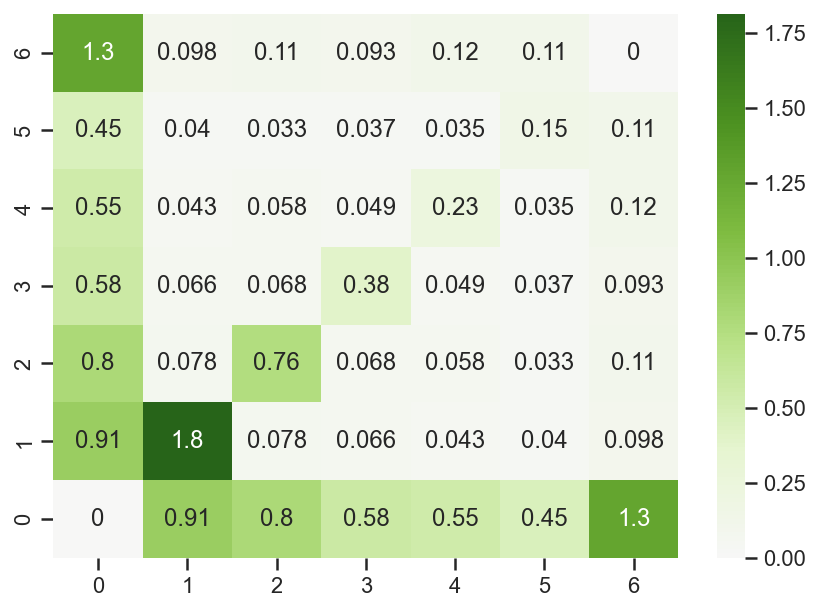

In [75]:
plt.subplots(1, 1, figsize=(7, 5))
ax = sns.heatmap(exp_mat, cmap="PiYG", 
                 center=0,
                annot=True
                )
ax.invert_yaxis()

### Covariance of ARG branches in the two populations

Covariance of ARG branches (with same nr of decendants at each locus) between populations

In [96]:
%%R -o cov_mat
fun <- function(a, b) mapply(function(i, j) covariance(tli_graph, rewards[props_to_index(s, i, j, 1),], rewards[props_to_index(s, i, j, 2),]), a, b)
cov_mat <- outer(1:(s-1), 1:(s-1), fun)

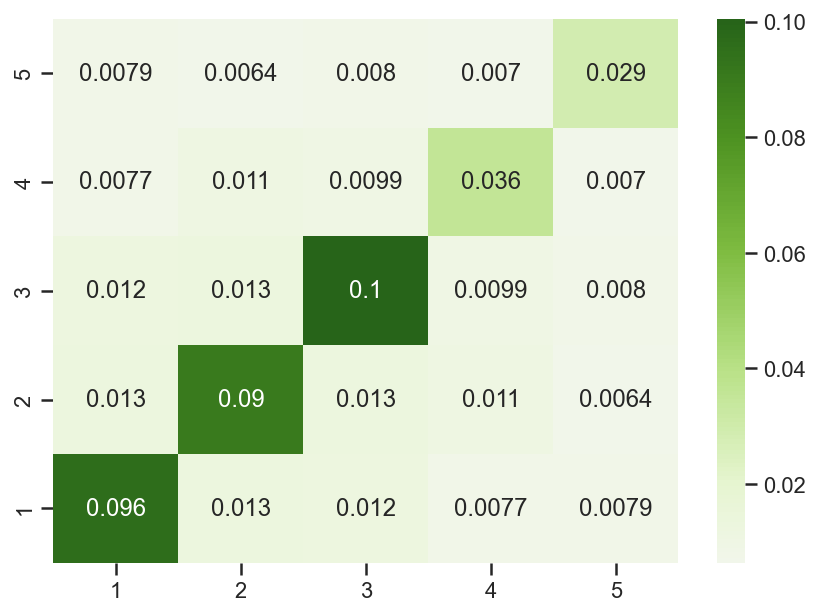

In [97]:
plt.subplots(1, 1, figsize=(7, 5))
ticks = list(range(1,int(s)))
ax = sns.heatmap(cov_mat, cmap="PiYG", 
                 center=0,
                yticklabels=ticks,
                xticklabels=ticks,
                annot=True
                )
ax.invert_yaxis()

### Covriance between tons at each locus

In [98]:
%%R -o cov_mat
r_props_to_index <- function(s, a, b, p) {
    return((p-1)*(s + 1)**2 + a*(s + 1) + b + 1)
}

locus1_rewards <- function(i) {
    colSums(rewards[r_props_to_index(s, i, 1:s, 1),]) + colSums(rewards[r_props_to_index(s, i, 1:s, 2),])
}
locus2_rewards <- function(j) {
    colSums(rewards[r_props_to_index(s, 1:s, j, 1),]) + colSums(rewards[r_props_to_index(s, 1:s, j, 2),])
}
fun <- function(a, b) mapply(function(i, j) covariance(tli_graph, locus1_rewards(i), locus2_rewards(j)), a, b)
cov_mat <- outer(1:(s-1), 1:(s-1), fun)

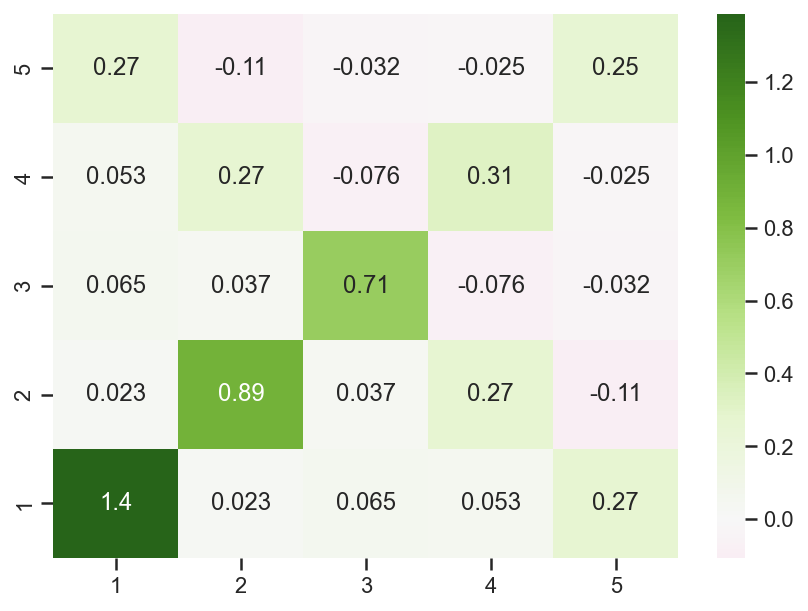

In [99]:
plt.subplots(1, 1, figsize=(7, 5))
ticks = list(range(1,int(s)))
ax = sns.heatmap(cov_mat, cmap="PiYG", 
                annot=True,
                center=0,
                yticklabels=ticks,
                xticklabels=ticks
                )
ax.invert_yaxis()

## Rabbit model

In [100]:
#Image("../images/rabbitislands.png", width=600)

In [3]:
%%R
Rcpp::sourceCpp("./rabbit_construction.cpp")

ld: warning: -pie being ignored. It is only used when linking a main executable


In [4]:
%%time
%%R
graph <- construct_rabbit_graph(1000, 4, 2)
print(vertices_length(graph))
expectation(graph)

[1] 501502


INFO: building reward compute graph...


[1] 0.3056984
CPU times: user 49.9 s, sys: 44.7 s, total: 1min 34s
Wall time: 2min 11s


In [102]:
%%R -o states -o ipv -o sim
L <- 2
  
tim <- proc.time()
state_vector_length <- 2
graph <- create_graph(state_vector_length)
starting_vertex <- vertex_at(graph, 1)
initial_state <- c(L, 0)

add_edge(
  starting_vertex,
  create_vertex(graph, initial_state),
  1
)
index <- 2

while (index <= vertices_length(graph)) {
  vertex <- vertex_at(graph, index)
  state <- vertex$state
  
  if (state[1] > 0) {
    # Rabbit jump left to right
    child_state <- c(state[1] - 1, state[2] + 1)
    add_edge(
      vertex,
      find_or_create_vertex(graph, child_state),
      1
      # 0, c(1, 0)
    )
    
    # Island flooding
    child_state <- c(0, state[2])
    add_edge(
      vertex,
      find_or_create_vertex(graph, child_state),
      2
      # 0, c(0, 1)

    )
  }
  
  if (state[2] > 0) {
    # Rabbit jump right to left
    child_state <- c(state[1] + 1, state[2] - 1)
    add_edge(
      vertex,
      find_or_create_vertex(graph, child_state),
      1
      # 0, c(1, 0)
    )
    
    # Island flooding
    child_state <- c(state[1], 0)
    add_edge(
      vertex,
      find_or_create_vertex(graph, child_state),
      4
      # 0, c(0, 2)
    )
  }
  
  index <- index + 1
}

states <- t(sapply(1:vertices_length(graph), function(index) vertex_at(graph, index)$state ))
ipv <- graph_as_matrix(graph)$IPV
sim <- graph_as_matrix(graph)$SIM

vertices_length(graph)

[1] 8


In [103]:
%%R
graph_update_weights_parameterized(graph, c(1, 2))

In [104]:
%%R
states <- t(sapply(1:vertices_length(graph), function(index) vertex_at(graph, index)$state ))
ipv <- graph_as_matrix(graph)$IPV
sim <- graph_as_matrix(graph)$SIM
states

     [,1] [,2]
[1,]    0    0
[2,]    2    0
[3,]    1    1
[4,]    0    0
[5,]    0    2
[6,]    0    1
[7,]    2    0
[8,]    1    0


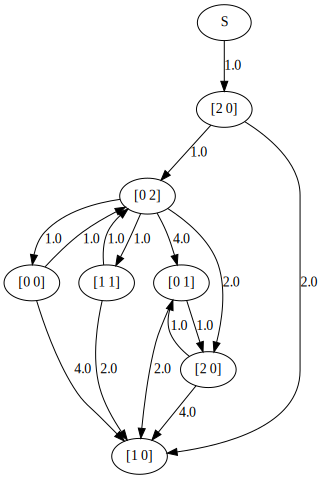

In [105]:
plot_graph(states, ipv, sim)

In [106]:
%%R
expectation(graph)

[1] 0.5038265


INFO: building reward compute graph...


## Running time experiments

In [ ]:
%%R

cat("rabbits,vertices,time_to_construct,time_build_moment_graph,time_compute_expectation,time_compute_first_10_moments\n")
flush.console()
for (L in c(10, 50, 100, 150, 200, 250, 300, 350, 400, 450, 500)) {
  
  tim <- proc.time()
  state_vector_length <- 2
  graph <- create_graph(state_vector_length)
  starting_vertex <- vertex_at(graph, 1)
  initial_state <- c(L, 0)
  cat(L)
  cat(",")
  flush.console()
  add_edge(
    starting_vertex,
    create_vertex(graph, initial_state),
    1
  )
  index <- 2
  
  while (index <= vertices_length(graph)) {
    vertex <- vertex_at(graph, index)
    state <- vertex$state
    
    if (state[1] > 0) {
      # Rabbit jump left to right
      child_state <- c(state[1] - 1, state[2] + 1)
      add_edge(
        vertex,
        find_or_create_vertex(graph, child_state),
        1
      )
      
      # Island flooding
      child_state <- c(0, state[2])
      add_edge(
        vertex,
        find_or_create_vertex(graph, child_state),
        1
      )
    }
    
    if (state[2] > 0) {
      # Rabbit jump right to left
      child_state <- c(state[1] + 1, state[2] - 1)
      add_edge(
        vertex,
        find_or_create_vertex(graph, child_state),
        1
      )
      
      # Island flooding
      child_state <- c(state[1], 0)
      add_edge(
        vertex,
        find_or_create_vertex(graph, child_state),
        1
      )
    }
    
    index <- index + 1
  }
  
  cat(vertices_length(graph))
  cat(",")
  now <- proc.time()
  cat((now - tim)[3])
  cat(",")
  flush.console()
  tim <- proc.time()
  expected_waiting_time(graph)
  now <- proc.time()
  cat((now - tim)[3])
  cat(",")
  flush.console()
  
  
  tim <- proc.time()
  expected_waiting_time(graph)
  now <- proc.time()
  cat((now - tim)[3])
  cat(",")
  flush.console()
  
  tim <- proc.time()
  
  rw <-  rep(1, vertices_length(graph))
  
  for (i in 1:10) {
    rw <- expected_waiting_time(graph, rw)
  }
  now <- proc.time()
  cat((now - tim)[3])
  cat("\n")
  flush.console()
}



cat("rabbits,vertices,time_convert_matrix,time_inverse_matrix\n")
flush.console()
for (L in c(10, 50, 100, 150, 200, 250, 300, 350, 400, 450, 500)) {
  
  tim <- proc.time()
  state_vector_length <- 2
  graph <- create_graph(state_vector_length)
  starting_vertex <- vertex_at(graph, 1)
  initial_state <- c(L, 0)
  cat(L)
  cat(",")
  flush.console()
  add_edge(
    starting_vertex,
    create_vertex(graph, initial_state),
    1
  )
  index <- 2
  
  while (index <= vertices_length(graph)) {
    vertex <- vertex_at(graph, index)
    state <- vertex$state
    
    if (state[1] > 0) {
      # Rabbit jump left to right
      child_state <- c(state[1] - 1, state[2] + 1)
      add_edge(
        vertex,
        find_or_create_vertex(graph, child_state),
        1
      )
      
      # Island flooding
      child_state <- c(0, state[2])
      add_edge(
        vertex,
        find_or_create_vertex(graph, child_state),
        1
      )
    }
    
    if (state[2] > 0) {
      # Rabbit jump right to left
      child_state <- c(state[1] + 1, state[2] - 1)
      add_edge(
        vertex,
        find_or_create_vertex(graph, child_state),
        1
      )
      
      # Island flooding
      child_state <- c(state[1], 0)
      add_edge(
        vertex,
        find_or_create_vertex(graph, child_state),
        1
      )
    }
    
    index <- index + 1
  }
  
  cat(vertices_length(graph))
  cat(",")
  flush.console()
  tim <- proc.time()
  M <- graph_as_matrix(graph)
  now <- proc.time()
  cat((now - tim)[3])
  cat(",")
  flush.console()
  
  
  tim <- proc.time()
  solve(M$SIM)
  now <- proc.time()
  cat((now - tim)[3])
  cat("\n")
  flush.console()
}

rabbits,vertices,time_to_construct,time_build_moment_graph,time_compute_expectation,time_compute_first_10_moments
10,68,0.006,0,0,0
50,1328,0.08,0.006,0.001,0.002
100,

INFO: building reward compute graph...
INFO: building reward compute graph...


5153,0.25,0.043,0.001,0.014
150,

INFO: building reward compute graph...


11478,0.54,0.111,0.005,0.045
200,

INFO: building reward compute graph...


20303,1.082,

INFO: building reward compute graph...


0.29,0.011,0.085
250,31628,1.488,

INFO: building reward compute graph...


0.505,0.021,0.183
300,45453,2.118,

INFO: building reward compute graph...


0.963,0.043,0.307
350,61778,3.405,

INFO: building reward compute graph...


1.229,0.06,0.424
400,80603,3.724,

INFO: building reward compute graph...


2.077,0.094,0.668
450,101928,5.205,

INFO: building reward compute graph...


3.223,0.126,1.025
500,125753,7.269,

INFO: building reward compute graph...


4.379,0.183,1.399
rabbits,vertices,time_convert_matrix,time_inverse_matrix
10,68,0,0.007
50,1328,0.018,0.191
100,5153,0.463,4.571
150,11478,2.182,43.934
200,20303,9.905,234.474
250,31628,39.531,